# 14.38 PS2 Notebook
I have selected study problems 1, 2, 3, and 7 from CM-1.

## Problem 1
We are interested in the large sample properties of 
$$\hat{\delta} = \hat{\theta}_1-\hat{\theta}_0$$
where 
$$\hat{\theta}_d = \frac{\mathbb{E}_nY(d)1(D=d)}{\mathbb{E}_n1(D=d)}$$
because $\hat{\delta}$ is an estimator of $\delta=\theta_1-\theta_0$.

We first consider the large sample properties of the vector $\hat{\theta} = \binom{\hat{\theta}_0}{\hat{\theta}_1}$. We have that

$$\hat{\theta}_d - \theta_d = \frac{\mathbb{E}_nY(d)1(D=d)}{\mathbb{E}_n1(D=d)} - E(Y(d))$$

and we can multiply by "one" to get

$$\hat{\theta}_d - \theta_d = \frac{\mathbb{E}_n[Y(d)-E(Y(d))]1(D=d)}{\mathbb{E}_n1(D=d)}$$

By the law of large numbers, the denominator converges to $P(D=d)$, and by the central limit theorem, because the numerator is a difference of a sample mean and its expectation for a sample where $D=d$, we have that

$$ \sqrt{n}(\hat{\theta}-\theta) \hspace{5pt} \overset{d}{\rightarrow} \hspace{5pt} \mathcal{N}(0, V) $$
where the covariance matrix $V$ is given by

$$V = \begin{pmatrix} \frac{Var(Y(0))}{P(D=0)} & Cov \\ Cov & \frac{Var(Y(1))}{P(D=1)} \end{pmatrix}$$

for some $Cov$. Because treatment is randomly assigned, we have that $Cov = 0$. Finally, we have that

$$\sqrt{n}(\hat{\delta} - \delta) = \sqrt{n}[(\hat{\theta}_1 - \hat{\theta}_0) - (\theta_1-\theta_0)] \hspace{5pt} \overset{d}{\rightarrow} \hspace{5pt} \mathcal{N}\left(0, \frac{Var(Y(0))}{P(D=0)} + \frac{Var(Y(1))}{P(D=1)}\right)$$

## Problem 2

In this problem, I replicate the 18-64 year old section of the table from the BioNTech/Pfizer vaccine RCT. The estimation of the Vaccine Effectiveness is fairly straightforward. The formula is given by

$$ VE = \frac{\text{Risk for Unvaccinated} - \text{Risk for Vaccinated}}{\text{Risk for Unvaccinated}}$$

We can plug in sample estimates of these numbers to estimate our $VE$. Estimating the standard errors is a little more complicated. We could use the Delta method along with the central limit theorem result to get a standard error that holds in large samples. However, in this notebook, we can run simulations or use the binomial nature of the random variables to construct standard errors and confidence intervals.

First, we estimate the vaccine effectivness.

In [87]:
# Here we calculate the overall effectiveness of the vaccine and construct confidence intervals for it

NV <- 14443
NU <- 14566
RV <- 8/NV
RU <- 149/NU
VE <- (RU - RV)/RU

cat("Overall VE is", round(VE, digits = 3))

Overall VE is 0.946

Now, we will estimate standard errors. The first method we will use is to calculate the variance of the risks used in the formula for $VE$, and simulate draws from distributions of those risks, calculating a $VE$ for each draw. This will give us a distribution of $VE$s, which allows us to construct a confidence interval as we might with a theoretical distribution.

[1] "95 % confidence interval is [ 0.905380054664249 , 0.983593615420864 ]"


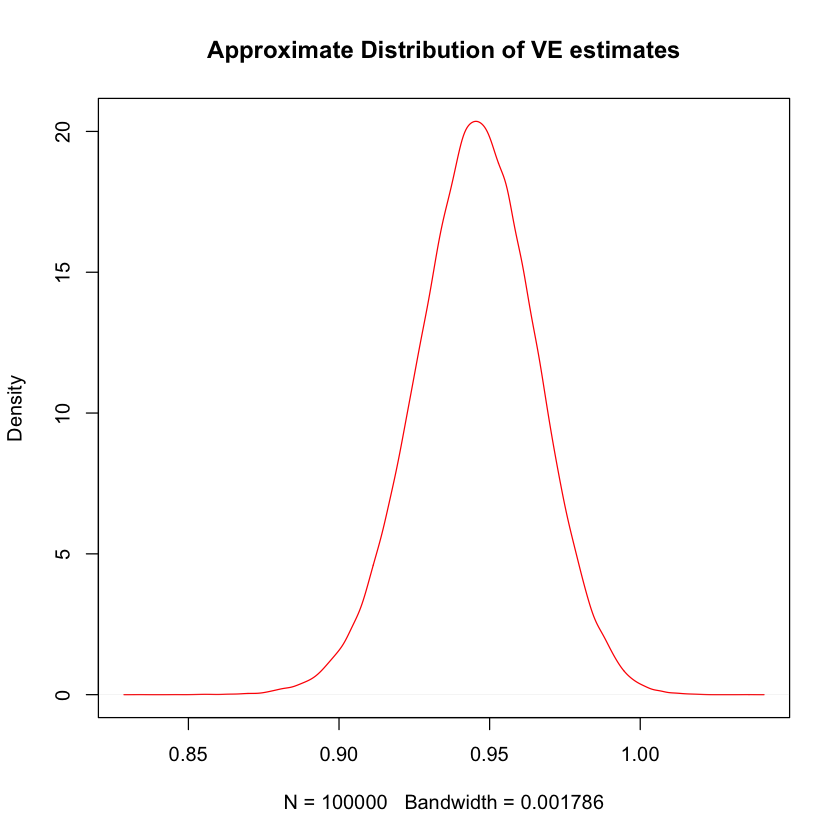

In [88]:
# construct variance according to Bernoulli
Var.RV = RV*(1-RV)/NV
Var.RU = RU*(1-RU)/NU

# set-up MC draws:
set.seed(3) #for reproducability

B = 100000
    RVs = RV  + rnorm(B)*sqrt(Var.RV)
    RUs = RU  + rnorm(B)*sqrt(Var.RU)
    VEs= (RUs - RVs)/RUs


plot(density(VEs), col=2, main="Approximate Distribution of VE estimates")

CI.VE =  quantile(VEs, c(.025, .975))


print(paste("95 % confidence interval is [", CI.VE[1], ",", 
            CI.VE[2], "]"   ), digits=4)

The distribution of $VE$s appears highly normal, which we would expect as a result from the Delta method.

We can also conduct a simulation where we construct a full data set, instead of just a distribution of $VE$s. Each outcome is Bernoulli random variable with probability either $RV$ or $RU$. Thus, our data can be transformed into binomial random variables. We draw directly from binomial distributions with the relevant parameters. Then, for a given set of binomial draws, we determine the $VE$.

[1] "95 % confidence interval is [ 0.903448275862069 , 0.980263157894737 ]"
[1] "1-sided 95 % confidence interval is [ 0.911392405063291 , 1 ]"


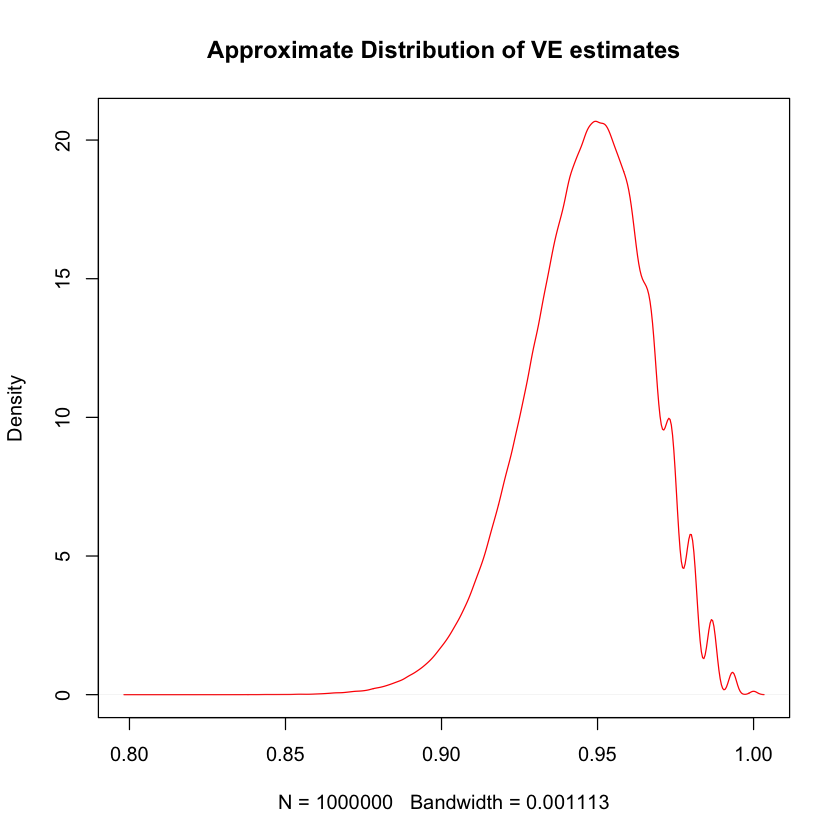

In [89]:
set.seed(3)

B = 10000 #number of simulation draw

    RVs = rbinom(1000000, size= NV, prob = RV) 
    RUs = rbinom(1000000, size= NU, prob = RU)
    VEs= (RUs - RVs)/RUs


plot(density(VEs), col=2, main="Approximate Distribution of VE estimates")

CI.VE =  quantile(VEs, c(.025, .975))


print(paste("95 % confidence interval is [", CI.VE[1], ",", 
            CI.VE[2], "]"   ))


OneSidedCI.VE =  quantile(VEs, c(.05))


print(paste("1-sided 95 % confidence interval is [", OneSidedCI.VE[1], ",",  1, "]"   ))

This gets us a very similar two sided confidence interval as before (although because of the discretized nature of binomial variables, the distribution apppears a bit strange). Finally, we can use a Cornfield exact test to get our confidence interval.

In [90]:
# Exact CI
library(ORCI)


CI <- 1 - Cornfieldexact.CI(9, NV, 169, NU, conf = 0.95, interval = c(1e-08, 1e+08))

L <- CI[2]
U <- CI[1]

print(paste("95 % confidence interval is [", L, ",", 
            U, "]"   ))

[1] "95 % confidence interval is [ 0.89670030362768 , 0.976136743391565 ]"


This gets us very near to the numbers in the table. The lower bound is about 0.5% too high, and the upper bound is about 0.1% too low, compared to the table. This is the closest, among the three methods used.

## Problem 3
In this question, we re-examine the Pennsylvania re-employment bonus experiment with a more flexible model than that in the original notebook. We are restricting our analysis to the difference between treatment group 4 and the control group. We will estimate the treatment effect on the variable of interest (log of amount of time before re-employment) using typical two means methods as well as regression methods.

First, we load up the data. 

In [91]:
library(tidyverse)
Penn <- as.data.frame(read.table("penn_jae.dat", header=T ))
n <- dim(Penn)[1]
p_1 <- dim(Penn)[2]
Penn<- filter(Penn, tg==4 | tg==0)
attach(Penn)

T4 <- (tg==4)


The following objects are masked from Penn (pos = 3):

    abdt, agegt54, agelt35, black, dep, durable, female, hispanic,
    husd, inuidur1, inuidur2, lusd, muld, nondurable, othrace, q1, q2,
    q3, q4, q5, q6, recall, tg

The following objects are masked from Penn (pos = 4):

    abdt, agegt54, agelt35, black, dep, durable, female, hispanic,
    husd, inuidur1, inuidur2, lusd, muld, nondurable, othrace, q1, q2,
    q3, q4, q5, q6, recall, tg

The following objects are masked from Penn (pos = 5):

    abdt, agegt54, agelt35, black, dep, durable, female, hispanic,
    husd, inuidur1, inuidur2, lusd, muld, nondurable, othrace, q1, q2,
    q3, q4, q5, q6, recall, tg

The following objects are masked from Penn (pos = 6):

    abdt, agegt54, agelt35, black, dep, durable, female, hispanic,
    husd, inuidur1, inuidur2, lusd, muld, nondurable, othrace, q1, q2,
    q3, q4, q5, q6, recall, tg

The following objects are masked from Penn (pos = 9):

    abdt, agegt54, agelt35, black, dep, durab

Next, we can input our model. This model uses the full set of fully interacted regressors from the data. We are also interested in testing the covariate balance between treatment and control groups. We are interested in this because it affects the validity of our interpretation of the two means estimator as the average treatment effect. Ideally, we would achieve ideal balance of our covariates between both groups.

In [92]:
m <- lm(T4~(abdt + female + black + hispanic + othrace + factor(dep) + q1 + q2 + q3 + q4 +
            q5 + q6 + recall + agelt35 + agegt54 + durable + nondurable + lusd + husd + muld)^2)

cat("Num of regressors:", length(m$coef))

library(lmtest)
library(sandwich)
coeftest(m, vcov = vcovHC(m, type="HC1"))

Num of regressors: 231


t test of coefficients:

                           Estimate  Std. Error t value Pr(>|t|)    
(Intercept)             -1.8323e+01  4.9004e+01 -0.3739 0.708489    
abdt                     1.6901e-03  4.5079e-03  0.3749 0.707737    
female                  -4.7978e+00  6.3258e+00 -0.7584 0.448221    
black                   -1.5627e+01  1.0236e+01 -1.5266 0.126914    
hispanic                -7.9558e+00  1.6594e+01 -0.4794 0.631656    
othrace                 -8.6884e+01  3.7932e+01 -2.2905 0.022033 *  
factor(dep)1            -1.8605e+01  9.4682e+00 -1.9650 0.049475 *  
factor(dep)2            -1.8924e+00  8.3586e+00 -0.2264 0.820898    
q1                       6.3112e+01  5.3882e+01  1.1713 0.241536    
q2                       1.8815e+01  4.8287e+01  0.3897 0.696809    
q3                       1.4623e+01  4.7987e+01  0.3047 0.760584    
q4                       1.3274e+01  4.8049e+01  0.2763 0.782354    
q5                       1.4459e+01  4.7958e+01  0.3015 0.763048    
recall  

Just as with the original model, we see that balance conditions fail here as well. This isn't surprising, given the amount of covariates which we are examining.

First, we can specify the model without adjustment (we use regression, but it is the same as the two means approach), and then specify the model with controls. We use OLS to estimate coefficients in both of these cases. We will interpret results at the end.

In [93]:
# no adjustment (2-sample approach)
formula_cl <- log(inuidur1)~T4

# adding controls
formula_cra <- log(inuidur1)~T4+ (abdt + female + black + hispanic + othrace + factor(dep) + q1 + q2 + q3 + q4 +
            q5 + q6 + recall + agelt35 + agegt54 + durable + nondurable + lusd + husd + muld)^2



ols.cl <- lm(formula_cl)
ols.cra <- lm(formula_cra)


ols.cl <- coeftest(ols.cl, vcov = vcovHC(ols.cl, type="HC1"))
ols.cra <- coeftest(ols.cra, vcov = vcovHC(ols.cra, type="HC1"))

print(ols.cl)
print(ols.cra)


t test of coefficients:

             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.056830   0.020955 98.1557  < 2e-16 ***
T4TRUE      -0.085455   0.035856 -2.3833  0.01719 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


t test of coefficients:

                           Estimate  Std. Error t value  Pr(>|t|)    
(Intercept)              1.9801e+02  1.2681e+02  1.5615 0.1184623    
T4TRUE                  -8.4319e-02  3.5428e-02 -2.3800 0.0173505 *  
abdt                    -1.8042e-02  1.1662e-02 -1.5470 0.1219159    
female                  -1.9409e+01  1.5592e+01 -1.2448 0.2132782    
black                   -4.1105e+01  2.7600e+01 -1.4893 0.1364706    
hispanic                -5.7988e+01  4.5989e+01 -1.2609 0.2074054    
othrace                  2.4898e+01  9.5528e+01  0.2606 0.7943879    
factor(dep)1            -4.3895e+00  2.4675e+01 -0.1779 0.8588150    
factor(dep)2            -4.3771e+00  2.0236e+01 -0.2163 0.8287604    
q1                

Now, we can estimate an interactive regression model with OLS. The interactive model is one in which we interact controls with our regressor of interest. It is important to demean your controls.

In [94]:
#interactive regression model;

X <- model.matrix (~ (abdt + female + black + hispanic + othrace + factor(dep) + q1 + q2 + q3 + q4 +
            q5 + q6 + recall + agelt35 + agegt54 + durable + nondurable + lusd + husd + muld)^2)[,-1]

demean<- function(x){ x - mean(x)}
X <- apply(X, 2, demean)

ols.ira <- lm(log(inuidur1) ~ T4*X) 
ols.ira <- coeftest(ols.ira, vcov = vcovHC(ols.ira, type="HC1"))
print(ols.ira)


t test of coefficients:

                                   Estimate  Std. Error t value  Pr(>|t|)    
(Intercept)                      2.0600e+00  2.0682e-02 99.6077 < 2.2e-16 ***
T4TRUE                          -8.0468e-02  3.5320e-02 -2.2783 0.0227538 *  
Xabdt                           -1.6102e-02  1.4424e-02 -1.1163 0.2643616    
Xfemale                         -7.3584e+00  2.0042e+01 -0.3671 0.7135252    
Xblack                          -7.4637e+01  3.4122e+01 -2.1874 0.0287630 *  
Xhispanic                       -4.0809e+01  5.3541e+01 -0.7622 0.4459744    
Xothrace                        -1.3142e+02  1.0215e+02 -1.2865 0.1983182    
Xfactor(dep)1                    8.9753e-01  3.0378e+01  0.0295 0.9764308    
Xfactor(dep)2                    1.7460e+01  2.5327e+01  0.6894 0.4906110    
Xq1                              3.1083e+01  1.7180e+02  0.1809 0.8564322    
Xq2                             -7.2650e+01  1.5405e+02 -0.4716 0.6372374    
Xq3                             -8.695

Finally, we can partial out with lasso.

In [95]:
library(hdm)

T4 <- demean(T4)

DX <- model.matrix(~T4*X)[,-1]

rlasso.ira <- summary(rlassoEffects(DX, log(inuidur1), index = 1))


print(rlasso.ira)

[1] "Estimates and significance testing of the effect of target variables"
   Estimate. Std. Error t value Pr(>|t|)  
T4  -0.08113    0.03530  -2.298   0.0215 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1




In [96]:
str(ols.ira)
ols.ira[2,1]

 'coeftest' num [1:362, 1:4] 2.06 -0.0805 -0.0161 -7.3584 -74.637 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:362] "(Intercept)" "T4TRUE" "Xabdt" "Xfemale" ...
  ..$ : chr [1:4] "Estimate" "Std. Error" "t value" "Pr(>|t|)"
 - attr(*, "method")= chr "t test of coefficients"


[1] -0.08046798

In [97]:
library(xtable)
table<- matrix(0, 2, 4)
table[1,1]<-  ols.cl[2,1]
table[1,2]<-  ols.cra[2,1]
table[1,3]<-  ols.ira[2,1]
table[1,4]<-  rlasso.ira[[1]][1]

table[2,1]<-  ols.cl[2,2]
table[2,2]<-  ols.cra[2,2]
table[2,3]<-  ols.ira[2,2]
table[2,4]<-  rlasso.ira[[1]][2]


colnames(table)<- c("CL","CRA","IRA", "IRA w Lasso")
rownames(table)<- c("estimate", "standard error")
tab<- xtable(table, digits=5)
tab

,CL,CRA,IRA,IRA w Lasso
estimate,-0.08545541,-0.08431877,-0.08046798,-0.08113410
standard error,0.03585569,0.03542803,0.03531951,0.03529873


We can see that when we use the more flexible model, our results differ slightly compared to the less flexible model used in the original notebook. Specifically, while the standard errors remain mostly the same, the magnitudes of the coefficients from the regression methods increase, and are closer to the unconditional estimate.

## Problem 7

Vaccination and unemployment trials are perfect examples of how time-dependent random elements prevent us from placing people into control and then treatment groups (or otherwise). For example, one element of exogeneous randomness that we would like to balance in vaccine trials is the exposure to the virus that individuals would experience. If we tried a consecutive control-treatment setup in October 2020 to January 2021, the exposure that individuals experienced in their daily lives would vastly increase from control to treatment periods. Therefore, their baseline risk during the treatment period would be much higher. If we have separate treatment and control groups during the same time period, any exogeneous, time-dependent covariates are automatically balanced.

Let's say we had a time machine, and could observe the same group go through treatment and control in the same time frame, then time dependent covariates would balance in a similar manner. Therefore, in this hypothetical world, we could (and perhaps even should!) assign people to both treatment and control groups. In fact, we could get perfect covariate balance if we were able to use the same individuals in treatment and control groups in the same time frame.